In [2]:
!pip install langdetect
!pip install datasets

import os
import ast
import re
import string
import time
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import tqdm
import collections
import gensim.downloader as api

from collections import Counter
from gensim.models import KeyedVectors, Word2Vec
from langdetect import detect
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Embedding
from datasets import Dataset


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

stop_words = set(stopwords.words('english'))


/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /

In [3]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing (Might be skipped, as named entity removal and english language detection give different result each time)

In [4]:
#Processed and splitted data can be loaded here
df_train = pd.read_csv('df_train_processed.csv')

df_test = pd.read_csv('df_test_processed.csv')
df_train
df_test['lemmatized'] = df_test['lemmatized'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df_train['lemmatized'] = df_train['lemmatized'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [15]:
df_train = pd.read_csv("sent_train.csv")
df_test = pd.read_csv("sent_valid.csv")

df = pd.concat([df_train, df_test], ignore_index=True)

def remove_dollar_words(text):
    return re.sub(r'\$\w+', '', text)

df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)

df['text'] = df['text'].apply(remove_dollar_words)

df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

df['text'] = df['text'].str.replace(r'\S*\d\S*', '', regex=True).str.replace(r'\d', '', regex=True)

df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '', regex=True)

df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)

nlp = spacy.load('en_core_web_sm')

def remove_named_entities_spacy(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.ent_type_]
    return tokens

df["text"] = df["text"].apply(remove_named_entities_spacy)

df['text'] = df['text'].apply(lambda x: ' '.join(x)).str.lower().str.strip()

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df['is_english'] = df['text'].apply(is_english)

df = df[df['is_english']].drop(columns=['is_english'])

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

def tokenize_text(text):
    return word_tokenize(text)

df['text'] = df['text'].apply(tokenize_text).apply(remove_stopwords)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def stem_words(tokens):
    return [stemmer.stem(word) for word in tokens]

def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

start_time = time.time()
df['stemmed'] = df['text'].apply(stem_words)
end_time = time.time()
print("Time taken for stemming (first run): {} seconds".format(end_time - start_time))

start_time = time.time()
df['stemmed'] = df['text'].apply(stem_words)
end_time = time.time()
print("Time taken for stemming (subsequent run): {} seconds".format(end_time - start_time))

start_time = time.time()
df['lemmatized'] = df['text'].apply(lemmatize_words)
end_time = time.time()
print("Time taken for lemmatization (first run): {} seconds".format(end_time - start_time))

start_time = time.time()
df['lemmatized'] = df['text'].apply(lemmatize_words)
end_time = time.time()
print("Time taken for lemmatization (subsequent run): {} seconds".format(end_time - start_time))

df_test['lemmatized'] = df_test['text'].apply(lemmatize_words)
df_test['stemmed'] = df_test['text'].apply(stem_words)

df['joined'] = df['lemmatized'].apply(lambda x: ' '.join(x))

print(df['label'].unique())
from sklearn.model_selection import train_test_split

duplicates = df.duplicated(subset='joined', keep=False)
df = df[~duplicates]

df_train, df_test = train_test_split(df,test_size=0.2, random_state=1234)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Time taken for stemming (first run): 5.735124111175537 seconds
Time taken for stemming (subsequent run): 4.876115322113037 seconds
Time taken for lemmatization (first run): 0.9163451194763184 seconds
Time taken for lemmatization (subsequent run): 1.3055834770202637 seconds
[0 1 2]


* Time taken for stemming (first run): 1.8569550514221191 seconds
* Time taken for stemming (subsequent run): 1.8586277961730957 seconds seconds
* Time taken for lemmatization (first run): 2.727806806564331 seconds
* Time taken for lemmatization (subsequent run): 0.3878641128540039 seconds


In [16]:
min_samples = len(df_train[df_train['label'] == 1])

df_majority_downsampled = resample(df_train[df_train['label'] == 2],
                                     replace=False,
                                     n_samples=min_samples,
                                     random_state=123)

df_train = pd.concat([df_majority_downsampled, df_train[df_train['label'] == 1], df_train[df_train['label'] == 0]])


In [5]:
df_train = df_train[df_train['lemmatized'].apply(len) > 2]
df_train

,text,label,stemmed,lemmatized,joined
0,"['direct', 'lenders', 'stay']",2,"['direct', 'lender', 'stay']","[direct, lender, stay]",direct lender stay
1,"['confirms', 'deal', 'sell', 'viagogo', 'purch...",2,"['confirm', 'deal', 'sell', 'viagogo', 'purcha...","[confirms, deal, sell, viagogo, purchase, pric...",confirms deal sell viagogo purchase price bill...
3,"['begun', 'streaming', 'wars', 'australias', '...",2,"['begun', 'stream', 'war', 'australia', 'entir...","[begun, streaming, war, australia, entire, def...",begun streaming war australia entire defense b...
4,"['smell', 'cooking', 'could', 'buy', 'analyst'...",2,"['smell', 'cook', 'could', 'buy', 'analyst', '...","[smell, cooking, could, buy, analyst, predicts]",smell cooking could buy analyst predicts
5,"['dear', 'moneyist', 'nt', 'want', 'money', 'g...",2,"['dear', 'moneyist', 'nt', 'want', 'money', 'g...","[dear, moneyist, nt, want, money, grab, friend...",dear moneyist nt want money grab friend lung d...
...,...,...,...,...,...
5754,"['shareholder', 'investigation', 'halper', 'sa...",0,"['sharehold', 'investig', 'halper', 'sadeh', '...","[shareholder, investigation, halper, sadeh, ll...",shareholder investigation halper sadeh llp inv...
5755,"['technipfmc', 'downgraded', 'called', 'top', ...",0,"['technipfmc', 'downgrad', 'call', 'top', 'pick']","[technipfmc, downgraded, called, top, pick]",technipfmc downgraded called top pick
5756,"['highest', 'level', 'pair', 'could', 'edge', ...",0,"['highest', 'level', 'pair', 'could', 'edg', '...","[highest, level, pair, could, edge, lower, tow...",highest level pair could edge lower toward vie...
5757,"['deputy', 'governor', 'said', 'interview', 'c...",0,"['deputi', 'governor', 'said', 'interview', 'c...","[deputy, governor, said, interview, central, b...",deputy governor said interview central bank mu...


In [17]:
df_train.to_csv('df_train_processed.csv', index=False)

df_test.to_csv('df_test_processed.csv', index=False)


## Dictionary approach + MultinomialNB

In [29]:
start_time = time.time()
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sia.polarity_scores(text)

df_test['sentiment'] = df_test['joined'].apply(get_sentiment)
df_test['compound'] = df_test['sentiment'].apply(lambda score_dict: score_dict['compound'])

def get_predicted_label(compound_score):
    if compound_score >= 0.05:
        return 1
    elif compound_score <= -0.05:
        return 0
    else:
        return 2

df_test['predicted_label'] = df_test['compound'].apply(get_predicted_label)
end_time = time.time()
time_t = end_time - start_time

In [30]:
accuracy = accuracy_score(df_test['label'], df_test['predicted_label'])
print(f'Accuracy: {accuracy}')
print(f'Time: {time_t}')

report = classification_report(df_test['label'], df_test['predicted_label'])
print(report)

Accuracy: 0.4845965770171149
Time: 2.1674978733062744
              precision    recall  f1-score   support

           0       0.39      0.40      0.40       451
           1       0.35      0.55      0.43       496
           2       0.67      0.49      0.56      1098

    accuracy                           0.48      2045
   macro avg       0.47      0.48      0.46      2045
weighted avg       0.53      0.48      0.49      2045



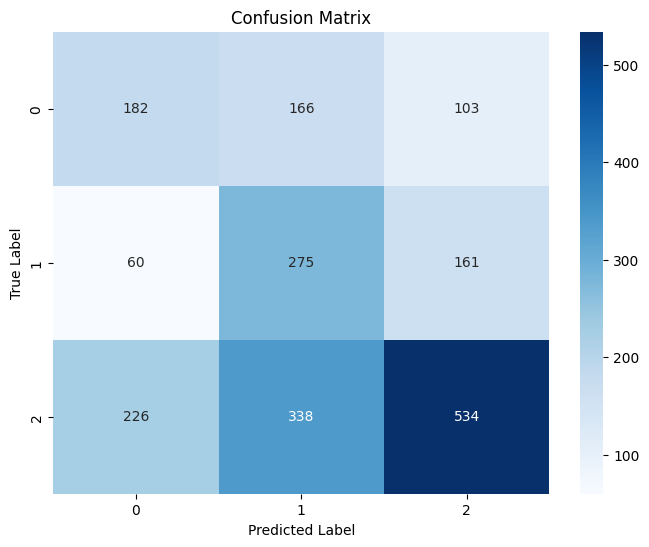

In [31]:
conf_matrix = confusion_matrix(df_test['label'], df_test['predicted_label'], labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Accuracy: 0.6484107579462103
Running time: 29.375569105148315
              precision    recall  f1-score   support

           0       0.50      0.46      0.48       451
           1       0.50      0.52      0.51       496
           2       0.77      0.79      0.78      1098

    accuracy                           0.65      2045
   macro avg       0.59      0.59      0.59      2045
weighted avg       0.65      0.65      0.65      2045



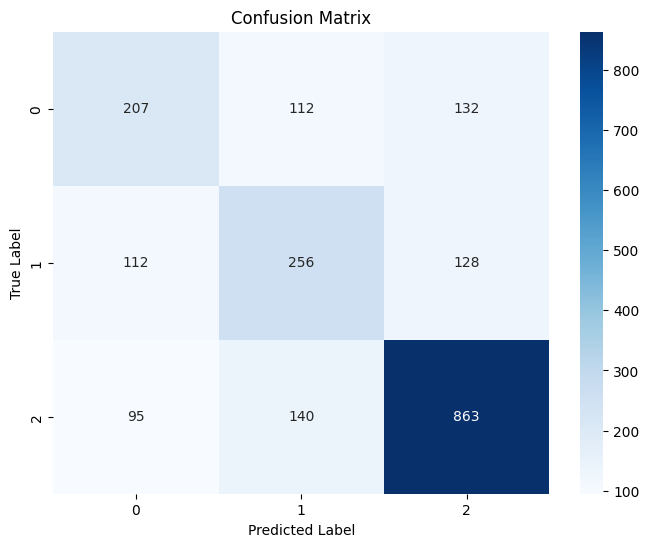

In [32]:
start_time = time.time()
X_train = df_train['joined']
y_train = df_train['label']

X_test = df_test['joined']
y_test = df_test['label']

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

end_time = time.time()

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(f"Running time: {end_time - start_time}")
report = classification_report(y_test, y_pred, zero_division=0)
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



Fitting 5 folds for each of 9 candidates, totalling 45 fits
Accuracy: 0.6352078239608802
Running time: 29.48464870452881
              precision    recall  f1-score   support

           0       0.51      0.61      0.56       451
           1       0.47      0.64      0.54       496
           2       0.86      0.64      0.74      1098

    accuracy                           0.64      2045
   macro avg       0.61      0.63      0.61      2045
weighted avg       0.69      0.64      0.65      2045



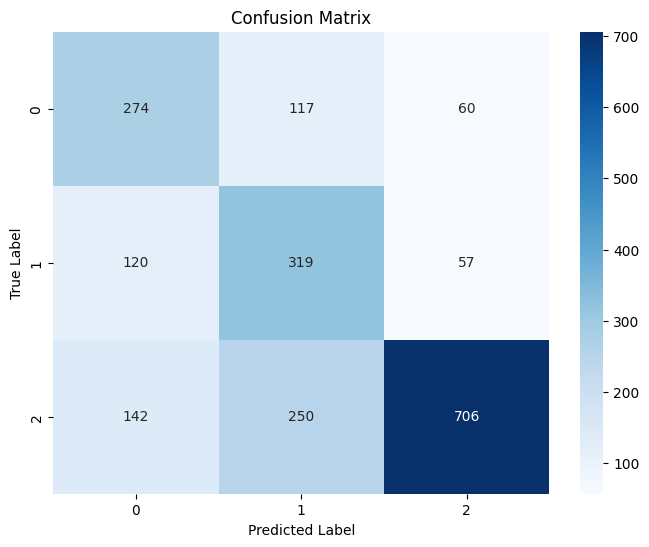

In [33]:
start_time = time.time()
X_train = df_train['joined']
y_train = df_train['label']

X_test = df_test['joined']
y_test = df_test['label']

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

end_time = time.time()

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(f"Running time: {end_time - start_time}")
report = classification_report(y_test, y_pred, zero_division=0)
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



## CNNs

### CNN + BoW

In [22]:
vectorizer = CountVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(df_train['joined']).toarray()
X_test = vectorizer.transform(df_test['joined']).toarray()

y_train = df_train['label'].values
y_test = df_test['label'].values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BoW_CNN(nn.Module):
    def __init__(self, input_dim):
        super(BoW_CNN, self).__init__()
        self.fc_reduce = nn.Linear(input_dim, 1024)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        conv_output_size = 1024 // 2
        self.fc1 = nn.Linear(conv_output_size * 100, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.fc_reduce(x)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = BoW_CNN(input_dim=5000).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.3f}')

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

end_time = time.time()
print(f'Training and evaluation took {end_time - start_time:.2f} seconds.')


Epoch 1/10: 100%|██████████| 87/87 [00:02<00:00, 34.78it/s]


Epoch [1/10], Loss: 1.440


Epoch 2/10: 100%|██████████| 87/87 [00:01<00:00, 83.56it/s]


Epoch [2/10], Loss: 0.753


Epoch 3/10: 100%|██████████| 87/87 [00:01<00:00, 84.51it/s]


Epoch [3/10], Loss: 0.497


Epoch 4/10: 100%|██████████| 87/87 [00:01<00:00, 85.03it/s]


Epoch [4/10], Loss: 0.293


Epoch 5/10: 100%|██████████| 87/87 [00:00<00:00, 88.42it/s]


Epoch [5/10], Loss: 0.202


Epoch 6/10: 100%|██████████| 87/87 [00:00<00:00, 89.32it/s]


Epoch [6/10], Loss: 0.131


Epoch 7/10: 100%|██████████| 87/87 [00:00<00:00, 90.16it/s]


Epoch [7/10], Loss: 0.078


Epoch 8/10: 100%|██████████| 87/87 [00:00<00:00, 89.06it/s]


Epoch [8/10], Loss: 0.055


Epoch 9/10: 100%|██████████| 87/87 [00:00<00:00, 89.16it/s]


Epoch [9/10], Loss: 0.036


Epoch 10/10: 100%|██████████| 87/87 [00:00<00:00, 89.50it/s]


Epoch [10/10], Loss: 0.032
Accuracy: 66.99%
Training and evaluation took 43.61 seconds.


Running time: 43.61320734024048
              precision    recall  f1-score   support

           0       0.61      0.45      0.52       451
           1       0.48      0.67      0.56       496
           2       0.82      0.76      0.79      1098

    accuracy                           0.67      2045
   macro avg       0.63      0.63      0.62      2045
weighted avg       0.69      0.67      0.67      2045



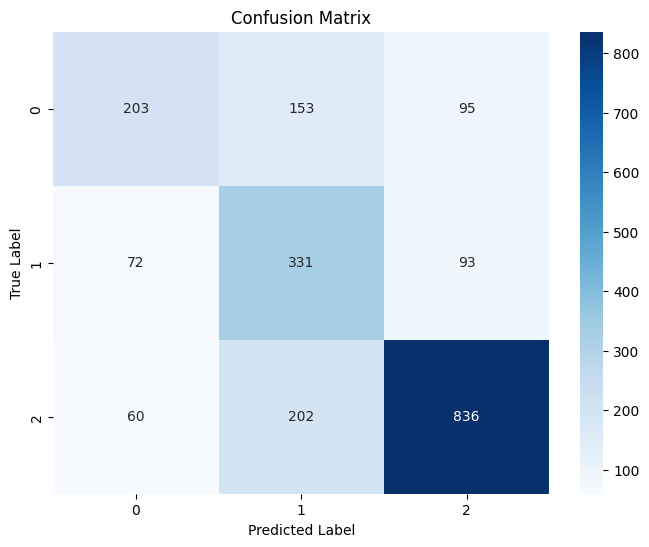

In [24]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Running time: {end_time - start_time}")
print(classification_report(all_labels, all_preds))

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### CNN + Word2Vec

In [6]:
train_data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

In [7]:
min_freq = 2
special_tokens = ["<unk>", "<pad>"]

word2vec_model = api.load("word2vec-google-news-300")

counter = Counter()
for tokens in train_data['lemmatized']:
    counter.update(tokens)

vocab = torchtext.vocab.vocab(counter, min_freq=min_freq, specials=special_tokens)

embedding_dim = word2vec_model.vector_size
pretrained_embedding = torch.zeros(len(vocab), embedding_dim)

unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

for i, token in enumerate(vocab.get_itos()):
    if token in word2vec_model:
        pretrained_embedding[i] = torch.tensor(word2vec_model[token])
    elif token == '<unk>':
        pretrained_embedding[i] = torch.randn(embedding_dim)
    elif token == '<pad>':
        pretrained_embedding[i] = torch.zeros(embedding_dim)
    else:
        pretrained_embedding[i] = pretrained_embedding[unk_index]

vocab.set_default_index(unk_index)

def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["lemmatized"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

train_data = train_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

batch_size = 500

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
          [
            nn.Conv2d(
            in_channels=1,
            out_channels=n_filters,
            kernel_size=(filter_size, embedding_dim)
            )
            for filter_size in filter_sizes
          ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        embedded = self.embedding(ids)

        embedded = embedded.unsqueeze(1)

        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        pooled = [torch.max(conv, dim=2).values for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim=1))

        prediction = self.fc(cat)

        return prediction

vocab_size = len(vocab)
embedding_dim = 300
n_filters = 50
filter_sizes = [1, 2, 3]
output_dim = len(train_data.unique("label"))
dropout_rate = 0.5

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

Map:   0%|          | 0/5506 [00:00<?, ? examples/s]

Map:   0%|          | 0/2045 [00:00<?, ? examples/s]

In [8]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

In [9]:
model.apply(initialize_weights)
model.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=False, padding_idx=pad_index)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [10]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [11]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [12]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [13]:
start_time = time.time()
n_epochs = 15
best_test_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["test_losses"].append(test_loss)
    metrics["test_accs"].append(test_acc)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {test_loss:.3f}, valid_acc: {test_acc:.3f}")
end_time = time.time()

evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.45it/s]


epoch: 0
train_loss: 1.114, train_acc: 0.396
valid_loss: 0.951, valid_acc: 0.575


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 25.73it/s]


epoch: 1
train_loss: 0.947, train_acc: 0.533
valid_loss: 0.891, valid_acc: 0.618


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 23.39it/s]


epoch: 2
train_loss: 0.892, train_acc: 0.616
valid_loss: 0.835, valid_acc: 0.665


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 20.24it/s]


epoch: 3
train_loss: 0.833, train_acc: 0.620
valid_loss: 0.790, valid_acc: 0.678


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 22.93it/s]


epoch: 4
train_loss: 0.761, train_acc: 0.683
valid_loss: 0.758, valid_acc: 0.688


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.92it/s]


epoch: 5
train_loss: 0.726, train_acc: 0.696
valid_loss: 0.741, valid_acc: 0.689


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 25.32it/s]


epoch: 6
train_loss: 0.669, train_acc: 0.729
valid_loss: 0.728, valid_acc: 0.696


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 25.20it/s]


epoch: 7
train_loss: 0.633, train_acc: 0.738
valid_loss: 0.707, valid_acc: 0.693


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.05it/s]


epoch: 8
train_loss: 0.554, train_acc: 0.782
valid_loss: 0.688, valid_acc: 0.711


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 19.11it/s]


epoch: 9
train_loss: 0.534, train_acc: 0.796
valid_loss: 0.690, valid_acc: 0.716


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 25.26it/s]


epoch: 10
train_loss: 0.488, train_acc: 0.824
valid_loss: 0.679, valid_acc: 0.715


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 25.09it/s]


epoch: 11
train_loss: 0.475, train_acc: 0.805
valid_loss: 0.678, valid_acc: 0.726


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.81it/s]


epoch: 12
train_loss: 0.424, train_acc: 0.848
valid_loss: 0.691, valid_acc: 0.721


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.71it/s]


epoch: 13
train_loss: 0.425, train_acc: 0.855
valid_loss: 0.679, valid_acc: 0.722


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 20.02it/s]

epoch: 14
train_loss: 0.403, train_acc: 0.845
valid_loss: 0.686, valid_acc: 0.725


Running time: 39.76504325866699
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       451
           1       0.62      0.60      0.61       496
           2       0.83      0.82      0.83      1098

    accuracy                           0.73      2045
   macro avg       0.69      0.69      0.69      2045
weighted avg       0.73      0.73      0.73      2045



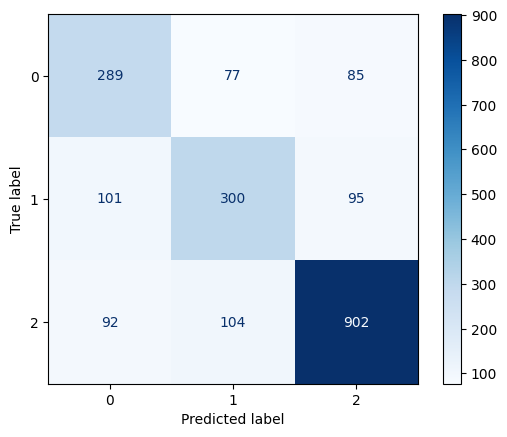

In [14]:
model.load_state_dict(torch.load("cnn.pt"))

def get_predictions(data_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

test_preds, test_labels = get_predictions(test_data_loader, model, device)

print(f"Running time: {end_time - start_time}")
report = classification_report(test_labels, test_preds, zero_division=0)
print(report)

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### CNN + GloVe

In [15]:
min_freq = 2
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data['lemmatized'],
    min_freq=min_freq,
    specials=special_tokens,
)
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(unk_index)

def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["lemmatized"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/5506 [00:00<?, ? examples/s]

Map:   0%|          | 0/2045 [00:00<?, ? examples/s]

In [16]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [17]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [18]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [19]:
batch_size = 500

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [20]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
          [
            nn.Conv2d(
            in_channels=1,
            out_channels=n_filters,
            kernel_size=(filter_size, embedding_dim)
            )
            for filter_size in filter_sizes
          ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        embedded = self.embedding(ids)

        embedded = embedded.unsqueeze(1)

        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        pooled = [torch.max(conv, dim=2).values for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim=1))

        prediction = self.fc(cat)

        return prediction


In [21]:
vocab_size = len(vocab)
embedding_dim = 300
n_filters = 50
filter_sizes = [1, 2, 3]
output_dim = len(train_data.unique("label"))
dropout_rate = 0.5

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

In [22]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

model.apply(initialize_weights)
vectors = torchtext.vocab.GloVe()


In [23]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [24]:
model.embedding.weight.data = pretrained_embedding

In [25]:
optimizer = optim.Adam(model.parameters())

In [26]:
criterion = nn.CrossEntropyLoss()

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
model = model.to(device)
criterion = criterion.to(device)

In [29]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [30]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [31]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [32]:
start_time = time.time()
n_epochs = 15
best_test_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["test_losses"].append(test_loss)
    metrics["test_accs"].append(test_acc)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {test_loss:.3f}, valid_acc: {test_acc:.3f}")
end_time = time.time()

evaluating...: 100%|██████████| 5/5 [00:00<00:00, 19.20it/s]


epoch: 0
train_loss: 1.011, train_acc: 0.463
valid_loss: 0.857, valid_acc: 0.610


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 25.27it/s]


epoch: 1
train_loss: 0.877, train_acc: 0.609
valid_loss: 0.783, valid_acc: 0.650


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.29it/s]


epoch: 2
train_loss: 0.808, train_acc: 0.621
valid_loss: 0.779, valid_acc: 0.665


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 25.11it/s]


epoch: 3
train_loss: 0.749, train_acc: 0.661
valid_loss: 0.758, valid_acc: 0.678


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 23.49it/s]


epoch: 4
train_loss: 0.715, train_acc: 0.676
valid_loss: 0.726, valid_acc: 0.712


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 19.39it/s]


epoch: 5
train_loss: 0.651, train_acc: 0.716
valid_loss: 0.715, valid_acc: 0.698


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.46it/s]


epoch: 6
train_loss: 0.654, train_acc: 0.708
valid_loss: 0.709, valid_acc: 0.698


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.99it/s]


epoch: 7
train_loss: 0.598, train_acc: 0.756
valid_loss: 0.697, valid_acc: 0.709


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]


epoch: 8
train_loss: 0.572, train_acc: 0.765
valid_loss: 0.692, valid_acc: 0.716


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.84it/s]


epoch: 9
train_loss: 0.578, train_acc: 0.774
valid_loss: 0.699, valid_acc: 0.686


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 19.93it/s]


epoch: 10
train_loss: 0.518, train_acc: 0.793
valid_loss: 0.697, valid_acc: 0.701


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 23.75it/s]


epoch: 11
train_loss: 0.485, train_acc: 0.821
valid_loss: 0.694, valid_acc: 0.711


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.27it/s]


epoch: 12
train_loss: 0.470, train_acc: 0.812
valid_loss: 0.691, valid_acc: 0.711


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.67it/s]


epoch: 13
train_loss: 0.468, train_acc: 0.818
valid_loss: 0.706, valid_acc: 0.701


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 24.28it/s]

epoch: 14
train_loss: 0.415, train_acc: 0.842
valid_loss: 0.686, valid_acc: 0.715


In [33]:
model.load_state_dict(torch.load("cnn.pt"))

def get_predictions(data_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

test_preds, test_labels = get_predictions(test_data_loader, model, device)

Running time: 39.387364625930786
              precision    recall  f1-score   support

           0       0.60      0.54      0.57       451
           1       0.58      0.65      0.61       496
           2       0.83      0.82      0.82      1098

    accuracy                           0.72      2045
   macro avg       0.67      0.67      0.67      2045
weighted avg       0.72      0.72      0.72      2045



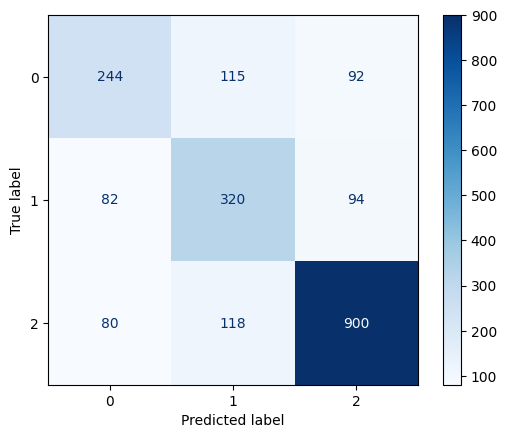

In [34]:
print(f"Running time: {end_time - start_time}")
report = classification_report(test_labels, test_preds, zero_division=0)
print(report)

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## RNNs

### RNN + BoW

In [62]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(df_train['joined']).toarray()
X_test_bow = vectorizer.transform(df_test['joined']).toarray()

X_train_tensor = torch.tensor(X_train_bow, dtype=torch.float32)
y_train_tensor = torch.tensor(df_train['label'].values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_bow, dtype=torch.float32)
y_test_tensor = torch.tensor(df_test['label'].values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

In [63]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
class BoWLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BoWLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        print(f'Input to LSTM shape: {x.shape}')
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        print(f'LSTM output shape: {hn.shape}')
        out = self.fc(hn[-1])
        print(f'Final output shape: {out.shape}')
        return out

input_size = X_train_bow.shape[1]
hidden_size = 128
output_size = 3

model = BoWLSTM(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)

        print(f'Predicted output shape: {output.shape}')
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.3f}%')
end_time = time.time()

Показано результат, скорочений до останніх рядків (5000).
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Predicted output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Predicted output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Predicted output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Predicted output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Predicted output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3

Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 11948])
LSTM output shape: torch.Size([1, 3, 128])
Final o

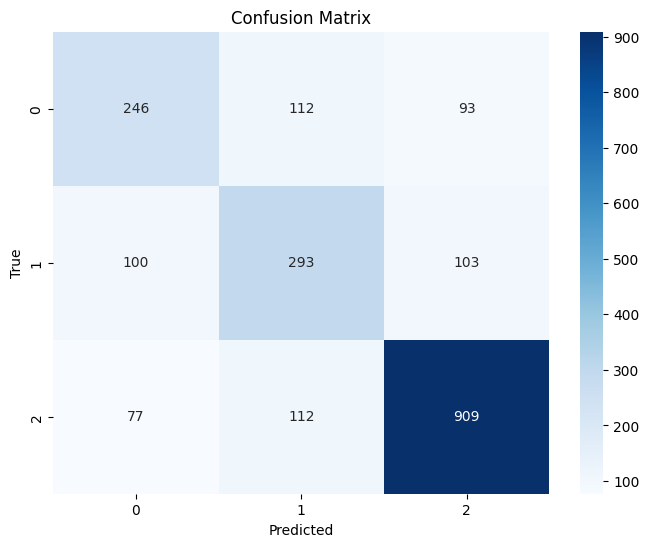

In [64]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
print(f'Accuracy: {accuracy:.3f}%')

print(f"Running time: {end_time - start_time}")
print(classification_report(all_labels, all_preds))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### RNN + Word2Vec

In [65]:
min_freq = 2
special_tokens = ["<unk>", "<pad>"]

#import gensim.downloader as api

#word2vec_model = api.load("word2vec-google-news-300")

train_data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

def add_length_column(example):
    example['length'] = len(example['lemmatized'])
    return example

train_data = train_data.map(add_length_column)
test_data = test_data.map(add_length_column)

counter = Counter()
for tokens in train_data['lemmatized']:
    counter.update(tokens)

vocab = torchtext.vocab.vocab(counter, min_freq=min_freq, specials=special_tokens)

embedding_dim = word2vec_model.vector_size
pretrained_embedding = torch.zeros(len(vocab), embedding_dim)
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

for i, token in enumerate(vocab.get_itos()):
    if token in word2vec_model:
        pretrained_embedding[i] = torch.tensor(word2vec_model[token])
    elif token == '<unk>':
        pretrained_embedding[i] = torch.randn(embedding_dim)
    elif token == '<pad>':
        pretrained_embedding[i] = torch.zeros(embedding_dim)
    else:
        pretrained_embedding[i] = pretrained_embedding[unk_index]

vocab.set_default_index(unk_index)

Map:   0%|          | 0/5506 [00:00<?, ? examples/s]

Map:   0%|          | 0/2045 [00:00<?, ? examples/s]

In [66]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["lemmatized"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

Map:   0%|          | 0/5506 [00:00<?, ? examples/s]

Map:   0%|          | 0/2045 [00:00<?, ? examples/s]

In [67]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [68]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        prediction = self.fc(hidden)
        return prediction

In [69]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [70]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 5,489,403 trainable parameters


In [71]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

model.apply(initialize_weights)

model.embedding = Embedding.from_pretrained(pretrained_embedding, freeze=False, padding_idx=pad_index)

lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


In [72]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [73]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


In [74]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [75]:
start_time = time.time()
n_epochs = 10
best_test_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["test_losses"].append(test_loss)
    metrics["test_accs"].append(test_acc)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {test_loss:.3f}, valid_acc: {test_acc:.3f}")
end_time = time.time()

evaluating...: 100%|██████████| 4/4 [00:00<00:00, 12.62it/s]


epoch: 0
train_loss: 1.064, train_acc: 0.413
valid_loss: 1.014, valid_acc: 0.476


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 10.63it/s]


epoch: 1
train_loss: 0.965, train_acc: 0.492
valid_loss: 0.829, valid_acc: 0.624


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 11.93it/s]


epoch: 2
train_loss: 0.859, train_acc: 0.568
valid_loss: 0.811, valid_acc: 0.631


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 11.91it/s]


epoch: 3
train_loss: 0.809, train_acc: 0.604
valid_loss: 0.766, valid_acc: 0.675


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 12.64it/s]


epoch: 4
train_loss: 0.756, train_acc: 0.644
valid_loss: 0.712, valid_acc: 0.705


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 12.63it/s]


epoch: 5
train_loss: 0.699, train_acc: 0.688
valid_loss: 0.708, valid_acc: 0.715


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 10.31it/s]


epoch: 6
train_loss: 0.650, train_acc: 0.716
valid_loss: 0.679, valid_acc: 0.730


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 12.67it/s]


epoch: 7
train_loss: 0.605, train_acc: 0.743
valid_loss: 0.674, valid_acc: 0.725


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 12.13it/s]


epoch: 8
train_loss: 0.562, train_acc: 0.764
valid_loss: 0.648, valid_acc: 0.745


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 12.08it/s]

epoch: 9
train_loss: 0.533, train_acc: 0.778
valid_loss: 0.654, valid_acc: 0.741


In [76]:
model.load_state_dict(torch.load("lstm.pt"))

def get_predictions(data_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["ids"].to(device)
            labels = batch["label"].to(device)
            lengths = batch["length"]

            outputs = model(inputs, lengths)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

test_preds, test_labels = get_predictions(test_data_loader, model, device)


Running time: 28.985252618789673
              precision    recall  f1-score   support

           0       0.66      0.58      0.62       451
           1       0.63      0.64      0.64       496
           2       0.82      0.86      0.84      1098

    accuracy                           0.75      2045
   macro avg       0.71      0.69      0.70      2045
weighted avg       0.74      0.75      0.74      2045



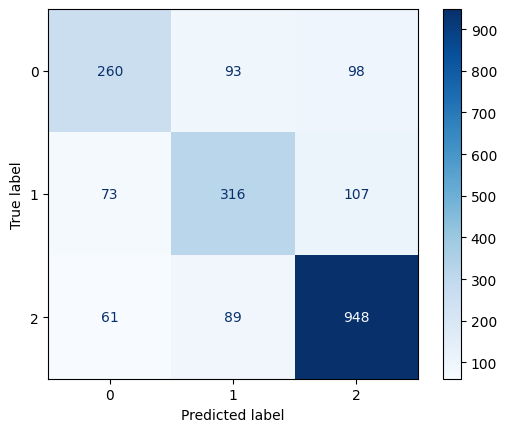

In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(f"Running time: {end_time - start_time}")
report = classification_report(test_labels, test_preds, zero_division=0)
print(report)

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### RNN + GloVe

In [19]:
train_data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

def add_length_column(example):
    example['length'] = len(example['lemmatized'])
    return example

train_data = train_data.map(add_length_column)
test_data = test_data.map(add_length_column)

Map:   0%|          | 0/5759 [00:00<?, ? examples/s]

Map:   0%|          | 0/2045 [00:00<?, ? examples/s]

In [20]:
min_freq = 2
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data['lemmatized'],
    min_freq=min_freq,
    specials=special_tokens,
)
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(unk_index)

def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["lemmatized"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/5759 [00:00<?, ? examples/s]

Map:   0%|          | 0/2045 [00:00<?, ? examples/s]

In [21]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [22]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [23]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [24]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [25]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        prediction = self.fc(hidden)
        return prediction

In [26]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [27]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [28]:
model.apply(initialize_weights)
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [29]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [30]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [31]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [32]:
start_time = time.time()
n_epochs = 10
best_test_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["test_losses"].append(test_loss)
    metrics["test_accs"].append(test_acc)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {test_loss:.3f}, valid_acc: {test_acc:.3f}")
end_time = time.time()

evaluating...: 100%|██████████| 4/4 [00:00<00:00, 13.46it/s]


epoch: 0
train_loss: 1.036, train_acc: 0.473
valid_loss: 0.888, valid_acc: 0.630


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 13.25it/s]


epoch: 1
train_loss: 0.885, train_acc: 0.579
valid_loss: 0.802, valid_acc: 0.648


evaluating...: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


epoch: 2
train_loss: 0.810, train_acc: 0.622
valid_loss: 0.751, valid_acc: 0.682


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 13.35it/s]


epoch: 3
train_loss: 0.770, train_acc: 0.644
valid_loss: 0.745, valid_acc: 0.685


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 12.97it/s]


epoch: 4
train_loss: 0.724, train_acc: 0.677
valid_loss: 0.712, valid_acc: 0.704


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 13.26it/s]


epoch: 5
train_loss: 0.688, train_acc: 0.701
valid_loss: 0.678, valid_acc: 0.724


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 10.68it/s]


epoch: 6
train_loss: 0.672, train_acc: 0.705
valid_loss: 0.668, valid_acc: 0.726


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 13.38it/s]


epoch: 7
train_loss: 0.641, train_acc: 0.727
valid_loss: 0.662, valid_acc: 0.727


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s]


epoch: 8
train_loss: 0.629, train_acc: 0.729
valid_loss: 0.688, valid_acc: 0.720


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 13.20it/s]

epoch: 9
train_loss: 0.599, train_acc: 0.745
valid_loss: 0.665, valid_acc: 0.736


In [33]:
model.load_state_dict(torch.load("lstm.pt"))

def get_predictions(data_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["ids"].to(device)
            labels = batch["label"].to(device)
            lengths = batch["length"]

            outputs = model(inputs, lengths)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

test_preds, test_labels = get_predictions(test_data_loader, model, device)


Running time: 32.01019883155823
              precision    recall  f1-score   support

           0       0.66      0.53      0.59       451
           1       0.58      0.64      0.61       496
           2       0.82      0.85      0.83      1098

    accuracy                           0.73      2045
   macro avg       0.69      0.67      0.68      2045
weighted avg       0.73      0.73      0.72      2045



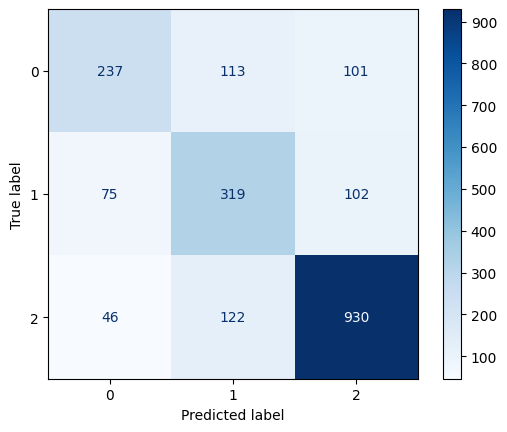

In [34]:
print(f"Running time: {end_time - start_time}")
report = classification_report(test_labels, test_preds, zero_division=0)
print(report)

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()